# Project 1: Customer Database
**This is the first of three mandatory projects to be handed in as part of the assessment for the course 02807 Computational Tools for Data Science at Technical University of Denmark, autumn 2019.**

#### Practical info
- **The project is to be done in groups of at most 3 students**
- **Each group has to hand in _one_ Jupyter notebook (this notebook) with their solution**
- **The hand-in of the notebook is due 2019-10-13, 23:59 on DTU Inside**

#### Your solution
- **Your solution should be in Python**
- **For each question you may use as many cells for your solution as you like**
- **You should document your solution and explain the choices you've made (for example by using multiple cells and use Markdown to assist the reader of the notebook)**
- **You should not remove the problem statements, and you should not modify the structure of the notebook**
- **Your notebook should be runnable, i.e., clicking [>>] in Jupyter should generate the result that you want to be assessed**
- **You are not expected to use machine learning to solve any of the exercises**
- **You will be assessed according to correctness and readability of your code, choice of solution, choice of tools and libraries, and documentation of your solution**

## Introduction
Your team has been hired by the company X as data scientists. X makes gadgets for a wide range of industrial and commercial clients.

As in-house data scientists, your teams first task, as per request from your new boss, is to optimize business operations. You have decided that a good first step would be to analyze the companys historical sales data to gain a better understanding of where profit is coming from. It may also reveal some low hanging fruit in terms of business opportunities.

To get started, you have called the IT department to get access to the customer and sales transactions database. To your horror you've been told that such a database doens't exist, and the only record of sales transactions is kept by John from finance in an Excel spreadsheet. So you've emailed John asking for a CSV dump of the spreadsheet...

In this project you need to clean the data you got from John, enrich it with further data, prepare a database for the data, and do some data analysis. The project is comprised of five parts. They are intended to be solved in the order they appear, but it is highly recommended that you read through all of them and devise an overall strategy before you start implementing anything.

## Part 1: Cleaning the data
John has emailed you the following link to the CSV dump you requested.

- [transactions.csv](https://raw.githubusercontent.com/patrickcording/02807-comp-tools/master/docker/work/data/transactions.csv)

It seems as though he has been a bit sloppy when keeping the records. 

In this part you should:
- Explain what the data is
- Clean it to prepare it for inserting into a database and doing data analysis 

---
### Solution

In [68]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime, timedelta
import string
import sqlite3
import matplotlib.pyplot as plt

In [69]:
data = pd.read_csv('https://raw.githubusercontent.com/patrickcording/02807-comp-tools/master/docker/work/data/transactions.csv')

## Describing the data
<br>
First we take a look at the data from som different perspectives.

In [70]:
# Let's look at the data.
data.head(10)

,part,company,country,city,price,date
0,54868-5165,Chatterbridge,Spain,Barcelona,784.79€,2016-01-02 00:01:05
1,60505-2867,Lajo,Greece,Thessaloniki,187.99€,2016-01-02 00:05:26
2,24385-268,Flipstorm,Greece,Athens,221.73€,2016-01-02 00:18:30
3,76117-001,Twitterbeat,France,Annecy,1075.82€,2016-01-02 02:32:30
4,44946-1046,Chatterbridge,Spain,Barcelona,412.55€,2016-01-02 04:51:55
5,16729-167,Chatterbridge,Spain,Barcelona,359.52€,2016-01-02 07:20:59
6,52125-444,Voomm,France,Paris,266.62€,2016-01-02 07:40:37
7,43419-018,Buzzbean,Germany,Düsseldorf,103.45€,2016-01-02 08:57:57
8,54092-515,Zooxo,United Kingdom,London,£704.94,2016-01-02 09:09:01
9,24286-1562,Lajo,Greece,Thessaloniki,317.65€,2016-01-02 11:01:32


We see that the data contains 6 columns for each observation and an index. We have the following columns:
* **part:** The identification number of the part that has been sold.
* **company:** The name of the company that the part was sold to.
* **country:** The country where the company is located.
* **city:** The city where the company is located.
* **price:** The price of the sale.
* **date:** The date and clock at which the part was sold.

We check the type of the data to understand if modification is required to utilize the data.

In [71]:
data.dtypes

part       object
company    object
country    object
city       object
price      object
date       object
dtype: object

We see that all data is stored at strings. Hence it will require some modification to achieve data that can actually be analyzed. Eg. the price should be converted to numerical values. Also it would make sense to convert the dates to a date time object. <br> <br>
Though the first ten lines suggests that the quality of the data is good, we check for missing data.

In [72]:
# Checking for NAs
data.isna().sum()

part         10
company       0
country    2171
city         33
price         1
date          0
dtype: int64

That is, we have a huge amount of missing data in the country coloumn. Luckily, this data is easily obtained from the city variable which we will take advantage of later.

## Cleaning the data
In the following we perform several modification to the data set to clean the data as well as achieving a more agile data set. In the cleaning process some few assumptions will be made, but they will be elaborated when appropiate. <br> <br>

Firstly, we extract the value and the valuta from the price coloumn, hence creating a new coloumn storing the valuta and keeping the **price** coloumn, now only storing the value. Data point that due not meet the requiements of containing a price followed by a currency symbol or negative price values are converted to NaN.

In [73]:
# Extracting the currency symbol
data['currency']=data['price'].str.extract(r'([€£$¥])')

# Extracting the price and converting it to numeric values.
data['price']=data['price'].str.strip('€£$¥')
data['price'] = data['price'].apply(pd.to_numeric, errors='coerce')
data['currency'] = data['currency'].where(data['price'] > 0, np.nan)
data['price'] = data['price'].where(data['price'] > 0, np.nan)

In [74]:
# Converting the currency symbol to the equivalent letter abbrevation.
oldCurrency = ['€', '£', '$', '¥']
newCurrency = ['EUR', 'GBP', 'USD', 'JPY']
data["currency"]=data["currency"].replace(oldCurrency, newCurrency)

<br>
Furthermore, we convert all date datapoints to datetime object to be able to work with these as true dates.

In [75]:
#Let's try to convert datetime to date and check the nans we get by coercing errors.
temp = [pd.to_datetime(i, format='%Y-%m-%d %H:%M:%S', errors='coerce') for i in data['date']]

# Print the dates that was not convertable
data.date[pd.isna(temp)]

3539     2016-06-32 07:22:28
3540     2016-06-32 08:08:48
9295             2017-04-08 
9296             2017-04-08 
9328              10/04/2017
9329              10/04/2017
9330              10/04/2017
9331              10/04/2017
9332              10/04/2017
9333              10/04/2017
9334              10/04/2017
19162            2018-10-13 
19163            2018-10-13 
19306            2018-10-21 
19307            2018-10-21 
19774            2018-11-17 
20197            2018-12-10 
20198            2018-12-10 
Name: date, dtype: object

Many of these either contain corrupt date or it is impossible to deduce what is month and what is date, these values are replaced with NaT values.
A few values should not be set to NaT, it's due to the format having a space to the furthest right, messing up the format for datetime. For these, we remove the space and convert them. Furthermore, we split the date variables in date and time into two coloumns.

In [76]:
# Split time and date
split_date=data.date.str.split(" ", expand=True)

We now construct two new data coloumns; One that only stores the date and one that stores the time.

In [77]:
# Keep only time.
data['time']=pd.to_datetime(split_date[1], format='%H:%M:%S', errors='coerce').dt.time
# Keep only date.
data['date']=pd.to_datetime(split_date[0], format='%Y-%m-%d',errors='coerce').dt.date

Using the value_counts() function from Pandas, we see some of the countries and cities are equipped with clear typos (Portuga) or different names for the same country (US and United States). These are converted manually to achieve a homogeneus data representaion. If a city or country do not match any known city or country, they are replaced by NaN.

In [78]:
# Replace country names
oldCountry=['Portuga','US','Tyskland']
newCountry = ['Portugal', 'United States', 'Germany']
data=data.replace(oldCountry, newCountry)

In [79]:
# # Replace city names
oldCompany=['Zooxo.', ' -', ' a', 'Laj0', 'aa', 'Ntagz', 'Thoughtmixz']
newCompany = ['Zooxo', 'np.nan', 'np.nan', 'Lajo', ' np.nan', 'Ntags', 'Thoughtmix']
data=data.replace(oldCompany,newCompany)

# We also have some invalid nans we convert to proper nans
data.company=data.company.str.lstrip().replace('np.nan', np.nan)

In [80]:
# We remove tab from Amadora
data['city']=data['city'].replace("Amadora\t", "Amadora")

As discussed previously, many countries are missing while the corresponding city is not. Using the data points where both city and country is available, makes imputing the missing countries from the cities a possibility.

In [81]:
unique_city = data['city'].dropna().unique()

# Find each unique country for city to impute
city_toCountry = {}

# Loop through all unique cities to find their matching country.
for city in unique_city:
    country=data['country'][data['city']==city].dropna().unique()
    # Making sure there are no more than 1 unique country of the city
    if country.shape[0] == 1:
        city_toCountry[city]=country[0]
    else:
        print("The city: " + city + " was found in more than one country: "+ country)
    

In [82]:
# Loop through the cities, inserting their corresponding country into the dataset.
for city in unique_city:
    mask = data['city']==city
    data.loc[mask,'country']=data.loc[mask,'country'].fillna(city_toCountry[city])


<br>
Finally, we also utilize that we know which currency is used in the different countries to impute missing currency types. First we check which currencies are available.

In [83]:
country = data['currency'].unique()[0:-1]
country

array(['EUR', 'GBP', 'USD', 'JPY'], dtype=object)

Hence, we can associate dollars to US, pound to GBP and YEN to Japan. For the remaining countries we check if other data points suggest that they use Euroes, and then put EUR as the currency for all observations in these countries.

In [84]:
EURcountries = data['country'][data['currency']=='EUR'].unique()[0:-1]

# Establish conditions in the same order as the list, values, containing the currencies.
conditions = [data['country'].isin(EURcountries) ,
              data['country'] == 'United Kingdom', 
              data['country'] == 'United States', 
              data['country']=='Japan']

# Apply the conditions and the currencies to all observations without currency.
data['currency'] = np.where(data['currency'].isnull(),np.select(conditions, country),data['currency'])

Finally we see the total amount of NaNs, which we can't do much about. However we don't remove the data with NaNs as it still may hold valuable information.

In [85]:
data.isna().sum()

part        10
company      3
country     30
city        33
price       84
date         9
currency     0
time        26
dtype: int64

---
## Part 2: Enriching the data

A common task for a data scientists is to combine or enrich data from internal sources with data available from external sources. The purpose of this can be either to fix issues with the data or to make it easier to derive insights from the data.

In this part you should enrich your data with data from at least one external source. You may look to part 4 for some  inspiration as to what is required. Your solution should be automated, i.e., you can not ask the reader of your notebook to download any data manually. You should argue why and what you expect to achieve by the enrichments you are doing.

---
### Solution

It is desirable to convert the different currencies to a single currency, by using exchange rates. Here the exchange rate for the Euro is used. This will standardize the different currencies to Euro and make it easier to perform an analysis based on the revenues.

In [86]:
# Get last and first day of the transactions to avoid downloading unused data
lastDate= str(max(data['date']))
firstDate = str(min(data['date'])-timedelta(days=2))
parameters = {'start_at': firstDate, 'end_at': lastDate , 'symbols' : 'JPY,USD,GBP'}

In [87]:
# Make request to get exchange rates for each day from: 
curr = requests.get('https://api.exchangeratesapi.io/history?' , params = parameters)
x = curr.json()
df1 = pd.DataFrame(x['rates'])

# Convert index to date and sort
rates = df1.transpose()
rates.index = pd.to_datetime(rates.index , format='%Y-%m-%d', errors='coerce').date
rates = rates.sort_index()

We see the exchange rates are not logged in the weekends, these values are imputed to be the fridays exchange rate value.

In [88]:
# Add rates with value 0 when no rate has been logged
idx = pd.date_range(firstDate, lastDate)
rates = rates.reindex(idx.date, fill_value=0)

# Run through all days. If rates are regristered they are saved in "rate". 
# If not, the zeros are replaced by the current value of "rate".
for i in range(len(rates)):
    if rates['GBP'][i] == 0:
        rates.iloc[i]=rate
    else:
        rate = rates.iloc[i]

# We drop the first dates as they were simply used to impute the data in case the first day i weekend
rates=rates.drop(rates.index[0:2])

In [89]:
# Find index where the values are not in euro
notEURMask = data['currency'] != 'EUR'
notEURIndex = list(notEURMask[notEURMask].index)

We now convert the prices using the found currency rates and save it to the dataframe:

In [90]:
temp=data['price'].copy()
for i in notEURIndex:
    # If valuta, date or price is not nan then we convert currency to euro, otherwise we set value to nan.
    valid = (pd.isna(data['price'][i]) or pd.isna(data['currency'][i]) or pd.isnull(data['date'][i]))
    if not valid:
        current_date = data['date'][i]
        valuta_used = data['currency'][i]
        exchange_rate = rates.loc[current_date].loc[valuta_used]
        temp[i] = float(temp[i]) / float(exchange_rate) 
    else:
        temp[i] = np.nan

In [91]:
# Save temp to dataframe
data['price_euro'] = temp

---
## Part 3: Creating a database
Storing data in a relational database has the advantages that it is persistent, fast to query, and it will be easier access for other employees at Weyland-Yutani.

In this part you should:
- Create a database and table(s) for the data
- Insert data into the tables

You may use SQLite locally to do this. You should argue why you choose to store your data the way you do. 

---
### Solution

It is decided to make the SQL database resemble the Pandas dataframe as much as possible, making any future retrievals from the database as intuitive and easy as possible.

In [92]:
conn = sqlite3.connect('customerDatabase.sqlite')
c = conn.cursor()

We define the objects for the database

In [93]:
transactionsDatabase = '''
CREATE TABLE IF NOT EXISTS customers (
    id INT,
    part STRING,
    company STRING,
    country STRING,
    city STRING,
    price REAL,
    date TIMESTAMP,
    currency STRING,
    time TIMESTAMP,
    price_euro REAL,
    PRIMARY KEY(id)
)
'''
c.execute(transactionsDatabase)
conn.commit()

We convert the data to SQL database called transactionDatabase

In [94]:
data.to_sql('transactionDatabase', conn, if_exists='replace', index=False)

---
## Part 4: Analyzing the data
You are now ready to analyze the data. Your goal is to gain some actionable business insights to present to your boss. 

In this part, you should ask some questions and try to answer them based on the data. You should write SQL queries to retrieve the data. For each question, you should state why it is relevant and what you expect to find.

To get you started, you should prepare answers to the following questions. You should add more questions.
#### Who are the most profitable clients?
Knowing which clients that generate the most revenue for the company will assist your boss in distributing customer service ressources.

#### Are there any clients for which profit is declining?
Declining profit from a specific client may indicate that the client is disatisfied with the product. Gaining a new client is often much more work than retaining one. Early warnings about declining profit may help your boss fighting customer churn.


Remember, you are taking this to your new boss, so think about how you present the data.

---
### Solution

- Who are the most profitable clients? <br>

Below the top 10 clients are seen, "Thoughtmix" and "Twitterbeat" seem to generate a lot of revenue. The total sale is specified in millions and Euro

In [95]:
X=10
#Limited to top 10, one can change the X for a different output.
query='''SELECT company , sum(price_euro)/1000000 as totalSale_Millions 
        FROM transactionDatabase 
        GROUP BY company 
        ORDER BY totalSale_Millions DESC
        LIMIT ?'''

pd.read_sql_query(query, conn, params=(X,))

,company,totalSale_Millions
0,Thoughtmix,1.626507
1,Twitterbeat,1.325826
2,Zooxo,0.997308
3,Shufflebeat,0.922396
4,Chatterbridge,0.920230
5,Ntags,0.845677
6,Brainsphere,0.721407
7,Buzzbean,0.714680
8,Flipstorm,0.674069
9,Wordify,0.533739


- Are there any clients for which profit is declining? <br>

From the plots below, it's clear that we see a downward trend from the companies "Voomm" and "Flipstorm". The trend for the rest looks more stationary. Something else to notice is that not many of the companies seem to be increasing revenue over time, which might indicate a stagnation problem.

In [107]:
# We make sure there is no NaNs or NaTs by using the IS NOT statement.
query = '''SELECT sum(price_euro) as revenue, company, strftime('%Y %m', date) as month 
        FROM transactionDatabase 
        WHERE month IS NOT NULL AND company IS NOT NULL AND price IS NOT NULL
        GROUP BY month, company 
        ORDER BY month'''

profit_decline=pd.read_sql_query(query,conn)

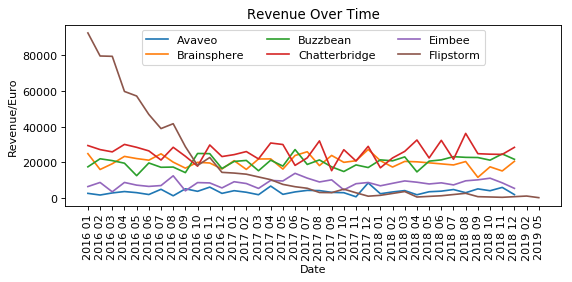

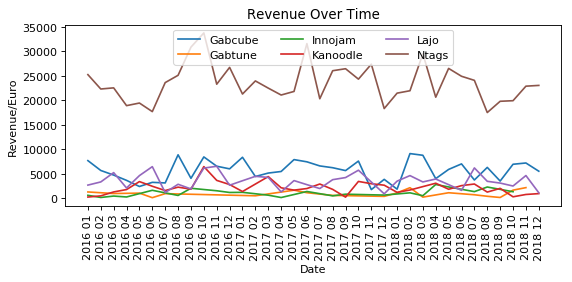

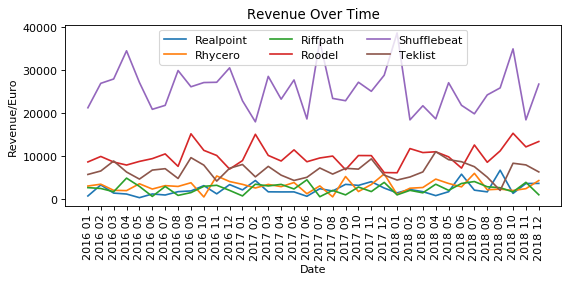

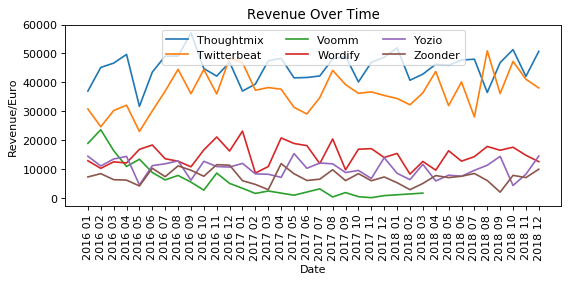

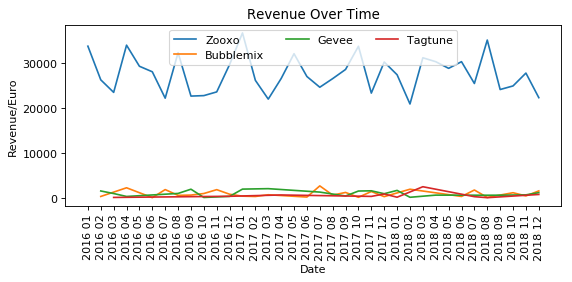

In [97]:
plt.figure(num=None, figsize=(8, 3), dpi=80, facecolor='w', edgecolor='k')

j = 0
for i in profit_decline.company.unique():
    j+=1
    df_dec_prof = profit_decline[profit_decline.company==i][["month", "revenue"]]
    df_dec_prof=df_dec_prof.sort_values(by='month')
    plt.plot(df_dec_prof.month,df_dec_prof.revenue, label=i);
    plt.title("Revenue Over Time")
    plt.ylabel("Revenue/Euro")
    plt.xlabel("Date")
    plt.xticks(rotation=90);
    plt.legend(loc="upper center", ncol=3)
    if j % 6 == 0:
        plt.show()
        plt.figure(num=None, figsize=(8, 3), dpi=80, facecolor='w', edgecolor='k')


- In which country and city are the most revenue generated in 2018? <br>

It is checked to see which country and city has the largest share of revenue for 2018 to 2019. It is seen that Portugal seems to be in the top, with Amadora taking the first place for cities, closely followed by the french city Annecy.

In [98]:
#Find total sale of parts
totalSaleDF = pd.read_sql_query('''SELECT sum(price_euro) as totalSale 
                                FROM transactionDatabase
                                WHERE date BETWEEN  "2018-01-01" AND "2019-01-01"''', conn)

totalSale = float(totalSaleDF['totalSale'].values)

X=10
#Find for countries
rev_country=pd.read_sql_query('''SELECT country, sum(price_euro)/?*100 as Percentage_Revenue 
                    FROM transactionDatabase 
                    WHERE date BETWEEN  "2018-01-01" AND "2019-01-01" AND price_euro IS NOT NULL AND country IS NOT NULL
                    GROUP BY country
                    ORDER BY Percentage_Revenue DESC''', conn , params = (totalSale,))
#Find for cities
rev_city=pd.read_sql_query('''SELECT city, sum(price_euro)/?*100 as Percentage_Revenue, country 
                    FROM transactionDatabase 
                    WHERE date BETWEEN  "2018-01-01" AND "2019-01-01" AND price_euro IS NOT NULL AND city IS NOT NULL
                    GROUP BY city
                    ORDER BY Percentage_Revenue DESC
                    LIMIT ?''', conn , params = (totalSale, X))

print(10*'#'+"Percentage revenue of total revenue for countries:"+10*'#')
print(rev_country)

print(10*'#'+"Percentage revenue of total revenue for top 10 cities and their respective country:"+10*'#')
print(rev_city[:10])

##########Percentage revenue of total revenue for countries:##########
          country  Percentage_Revenue
0        Portugal           42.533368
1          France           17.864996
2  United Kingdom            8.892213
3           Spain            8.445104
4         Germany            6.964042
5   United States            6.642040
6          Greece            5.173530
7     Netherlands            2.554780
8           Japan            0.745389
9     Switzerland            0.108102
##########Percentage revenue of total revenue for top 10 cities and their respective country:##########
         city  Percentage_Revenue         country
0     Amadora           14.855216        Portugal
1      Annecy           12.449141          France
2      London            8.892213  United Kingdom
3   Barcelona            8.445104           Spain
4      Lisbon            8.259680        Portugal
5       Porto            8.022957        Portugal
6  Düsseldorf            6.964042         Germany
7      

- Any difference in sales per season? <br>

It is checked if there is a large difference in parts sold based on the different seasons. It is seen that the numbers are fairly close to each other indicating the current season does not matter much. However there is a slight increase during the first 3 months, which could suggest a larger interest in parts at the start of the year.

In [99]:
#We exclude 2019 due to only 2 recorded transactions that year.
pd.read_sql_query('''SELECT strftime("%m", date)%4 + 1  as Quarter, sum(price_euro)/1000000 as Quarter_Sale_Millions 
                    FROM transactionDatabase
                    WHERE date IS NOT NULL AND date < "2019-01-01"
                    GROUP BY Quarter
                    ORDER BY Quarter_Sale_Millions DESC''', conn)


,Quarter,Quarter_Sale_Millions
0,1,3.054769
1,2,2.946894
2,4,2.939059
3,3,2.930275


- What about months? <br>

Like for the quarters we can also investigate each month. As expected from the previous data extraction, the share is very steady with a tiny advantage to the first months.

In [100]:
pd.read_sql_query('''SELECT strftime("%m", date)  as Month, sum(price_euro)/1000000 as Total_Sale_Millions 
                  FROM transactionDatabase
                  WHERE date IS NOT NULL
                  GROUP BY Month
                  ORDER BY Month''', conn)

,Month,Total_Sale_Millions
0,01,1.047772
1,02,0.957577
2,03,1.010862
3,04,1.027513
4,05,0.959154
5,06,0.975546
6,07,0.962091
7,08,1.042681
8,09,0.940108
9,10,0.998203


- Which part sells best and worst?

Looking at the sale of each type of part we see that one part, 17156-617, clearly represents a large part of the revenue by almost the double of the part that is sold the second most times. However it's average price per part is also 997 Euro, a high price comparing the other parts. One can also use the data to investigate if a part sells well or if it does not, if the part sells a lot, but the total revenue is low, it might indicate that the price per part should increase for a better total revenue, however more information is needed to conclude anything.

In [101]:
best_sale=pd.read_sql_query('''SELECT part  as Part, COUNT(part) as N_Part, sum(price_euro)/1000000 as Total_Revenue_Million,
                    sum(price_euro)/(COUNT(PART)) as Average_Revenue
                  FROM transactionDatabase
                  WHERE part IS NOT NULL
                  GROUP BY Part
                  ORDER BY N_Part DESC''', conn)
print(10*'#'+"Parts that sold the most:"+10*'#')
print(best_sale[:9])

print(10*'#'+"Parts that sold the least:"+10*'#')
print(best_sale[-10:])

##########Parts that sold the most:##########
         Part  N_Part  Total_Revenue_Million  Average_Revenue
0   17156-617     300               0.299205       997.351289
1   37205-992     295               0.156511       530.545095
2   0268-6107     293               0.140140       478.293175
3   52959-433     293               0.097960       334.334261
4  54868-0823     292               0.045765       156.729005
5  62011-0219     291               0.241015       828.230596
6   51346-145     289               0.280375       970.155560
7   13537-259     287               0.209948       731.525213
8  58118-5060     286               0.060489       211.499641
##########Parts that sold the least:##########
          Part  N_Part  Total_Revenue_Million  Average_Revenue
90   59779-601     126               0.020810       165.155655
91  49288-0285     124               0.115364       930.355178
92   76117-001     124               0.120914       975.110343
93   16477-306     117             

- Is there a particular time of the day where parts sell best?

We check if there a specific hour during the day where sales are best. However it seems like it is not the case as the series in the figure looks stochastic.

In [102]:
parts_by_hour=pd.read_sql_query('''SELECT COUNT(part) as N_Part, strftime('%H', time) as hour
                  FROM transactionDatabase
                  WHERE part IS NOT NULL AND hour IS NOT NULL
                  GROUP BY hour''', conn)

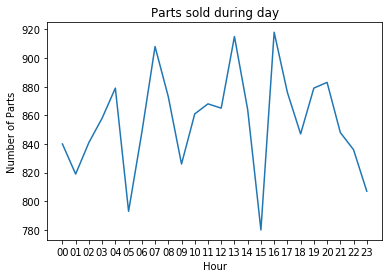

In [108]:
plt.plot(parts_by_hour.hour, parts_by_hour.N_Part)
plt.xlabel("Hour")
plt.ylabel("Number of Parts")
plt.title("Parts sold during day")
plt.show()

---
## Part 5: Performance
Your boss is very impressed with what you have achieved in less than two weeks, and he would like to take your idea of storing the customer and sales data in a relational database to production. However, John is concerned that the solution will not scale. His experience is telling him that you will see many occurrences of the following queries.

- Show all sales to company X between time $t_1$ and time $t_2$
- Show the latest X sales in the database
- Show total sales per company per day

Show that Johns concern is not justified.

---
### Solution

- Show all sales to company X between time $t_1$ and time $t_2$ <br><br>
The cell below extract all sales to a given company between two time periods. The user can specify the two dates of interest by modifying the two strings $t_1$ and $t_2$. Finally, the company name is specified in the company string. In the example below, we extract all sales to the company Brainsphere from january 1st 2016 to January 1st 2019. We see that the company has accomplished 1241 sales. 

In [104]:
t1 = '2016-01-01'
t2 = '2019-01-01'
company = 'Brainsphere'

query = "SELECT * FROM transactionDatabase WHERE company = ? AND date  BETWEEN ? AND ?"
pd.read_sql_query(query,  conn , params = (company,t1,t2))

,part,company,country,city,price,date,currency,time,price_euro
0,36987-1697,Brainsphere,Portugal,Braga,830.75,2016-01-02,EUR,13:16:45.000000,830.75
1,49288-0285,Brainsphere,Portugal,Braga,598.52,2016-01-02,EUR,22:18:14.000000,598.52
2,16714-295,Brainsphere,Portugal,Braga,712.31,2016-01-04,EUR,01:07:00.000000,712.31
3,98132-889,Brainsphere,Portugal,Braga,236.03,2016-01-04,EUR,16:42:33.000000,236.03
4,10267-2529,Brainsphere,Portugal,Braga,528.52,2016-01-05,EUR,19:35:12.000000,528.52
5,0228-2167,Brainsphere,Portugal,Braga,946.63,2016-01-06,EUR,04:41:37.000000,946.63
6,63629-2733,Brainsphere,Portugal,Braga,255.41,2016-01-07,EUR,08:29:28.000000,255.41
7,62011-0219,Brainsphere,Portugal,Braga,925.83,2016-01-07,EUR,08:55:32.000000,925.83
8,24385-268,Brainsphere,Portugal,Braga,200.13,2016-01-08,EUR,14:06:06.000000,200.13
9,52959-433,Brainsphere,Portugal,Braga,328.54,2016-01-08,EUR,22:16:38.000000,328.54


- Show the latest X sales in the database <br><br>
The cell below extracts the latest X sales from the database by ordering the data by dates and limiting the number of rows to X. We see that the 10th latest sale was performed at December 31 2018.

In [105]:
X = 10
query = "SELECT * FROM transactionDatabase ORDER BY date DESC LIMIT ?"
pd.read_sql_query(query,  conn , params = (X,) )

,part,company,country,city,price,date,currency,time,price_euro
0,43419-018,Flipstorm,Greece,Athens,139.56,2019-05-14,EUR,22:48:39.000000,139.560000
1,49288-0285,Flipstorm,Greece,Athens,1051.08,2019-02-21,EUR,20:05:00.000000,1051.080000
2,49349-842,Zoonder,United States,Boston,476.66,2018-12-31,USD,02:24:27.000000,416.296943
3,0699-7041,Twitterbeat,France,Annecy,665.30,2018-12-31,EUR,02:35:27.000000,665.300000
4,68180-121,Rhycero,France,Arcueil,936.06,2018-12-31,EUR,03:13:36.000000,936.060000
5,51060-032,Buzzbean,Germany,Düsseldorf,378.98,2018-12-31,EUR,05:13:28.000000,378.980000
6,0268-6107,Thoughtmix,Portugal,Amadora,477.59,2018-12-31,EUR,13:32:57.000000,477.590000
7,68180-121,Twitterbeat,France,Annecy,637.50,2018-12-31,EUR,13:53:59.000000,637.500000
8,13537-259,Thoughtmix,Portugal,Amadora,762.29,2018-12-31,EUR,14:17:24.000000,762.290000
9,36800-952,Gabcube,Portugal,Almada,286.23,2018-12-31,EUR,16:27:34.000000,286.230000


- Show total sales per company per day <br>

Below a table containing the average revenue generated per active company pr. day is found. There are 1097 different combinations and the most active day was at May 22 2016 when 15 companies bought parts for ~13906.88 EUR on average per company.

In [106]:
query = '''SELECT date as Date , sum(price) as TotalSale, count(company) as NumberOfCompanies , 
            sum(price)/count(company) as SalePerCompany 
            FROM transactionDatabase 
            GROUP BY date 
            ORDER BY SalePerCompany DESC'''
pd.read_sql_query(query,  conn)

,Date,TotalSale,NumberOfCompanies,SalePerCompany
0,2016-05-22,208603.17,15,13906.878000
1,2017-11-07,136073.17,10,13607.317000
2,2016-12-17,160480.41,16,10030.025625
3,2018-12-17,105919.99,11,9629.090000
4,2016-12-24,191337.92,20,9566.896000
5,2018-12-08,218498.06,23,9499.915652
6,2017-10-31,194908.42,21,9281.353333
7,2017-07-24,118692.91,13,9130.223846
8,2016-06-29,117662.39,13,9050.953077
9,2017-09-05,132805.20,15,8853.680000


---